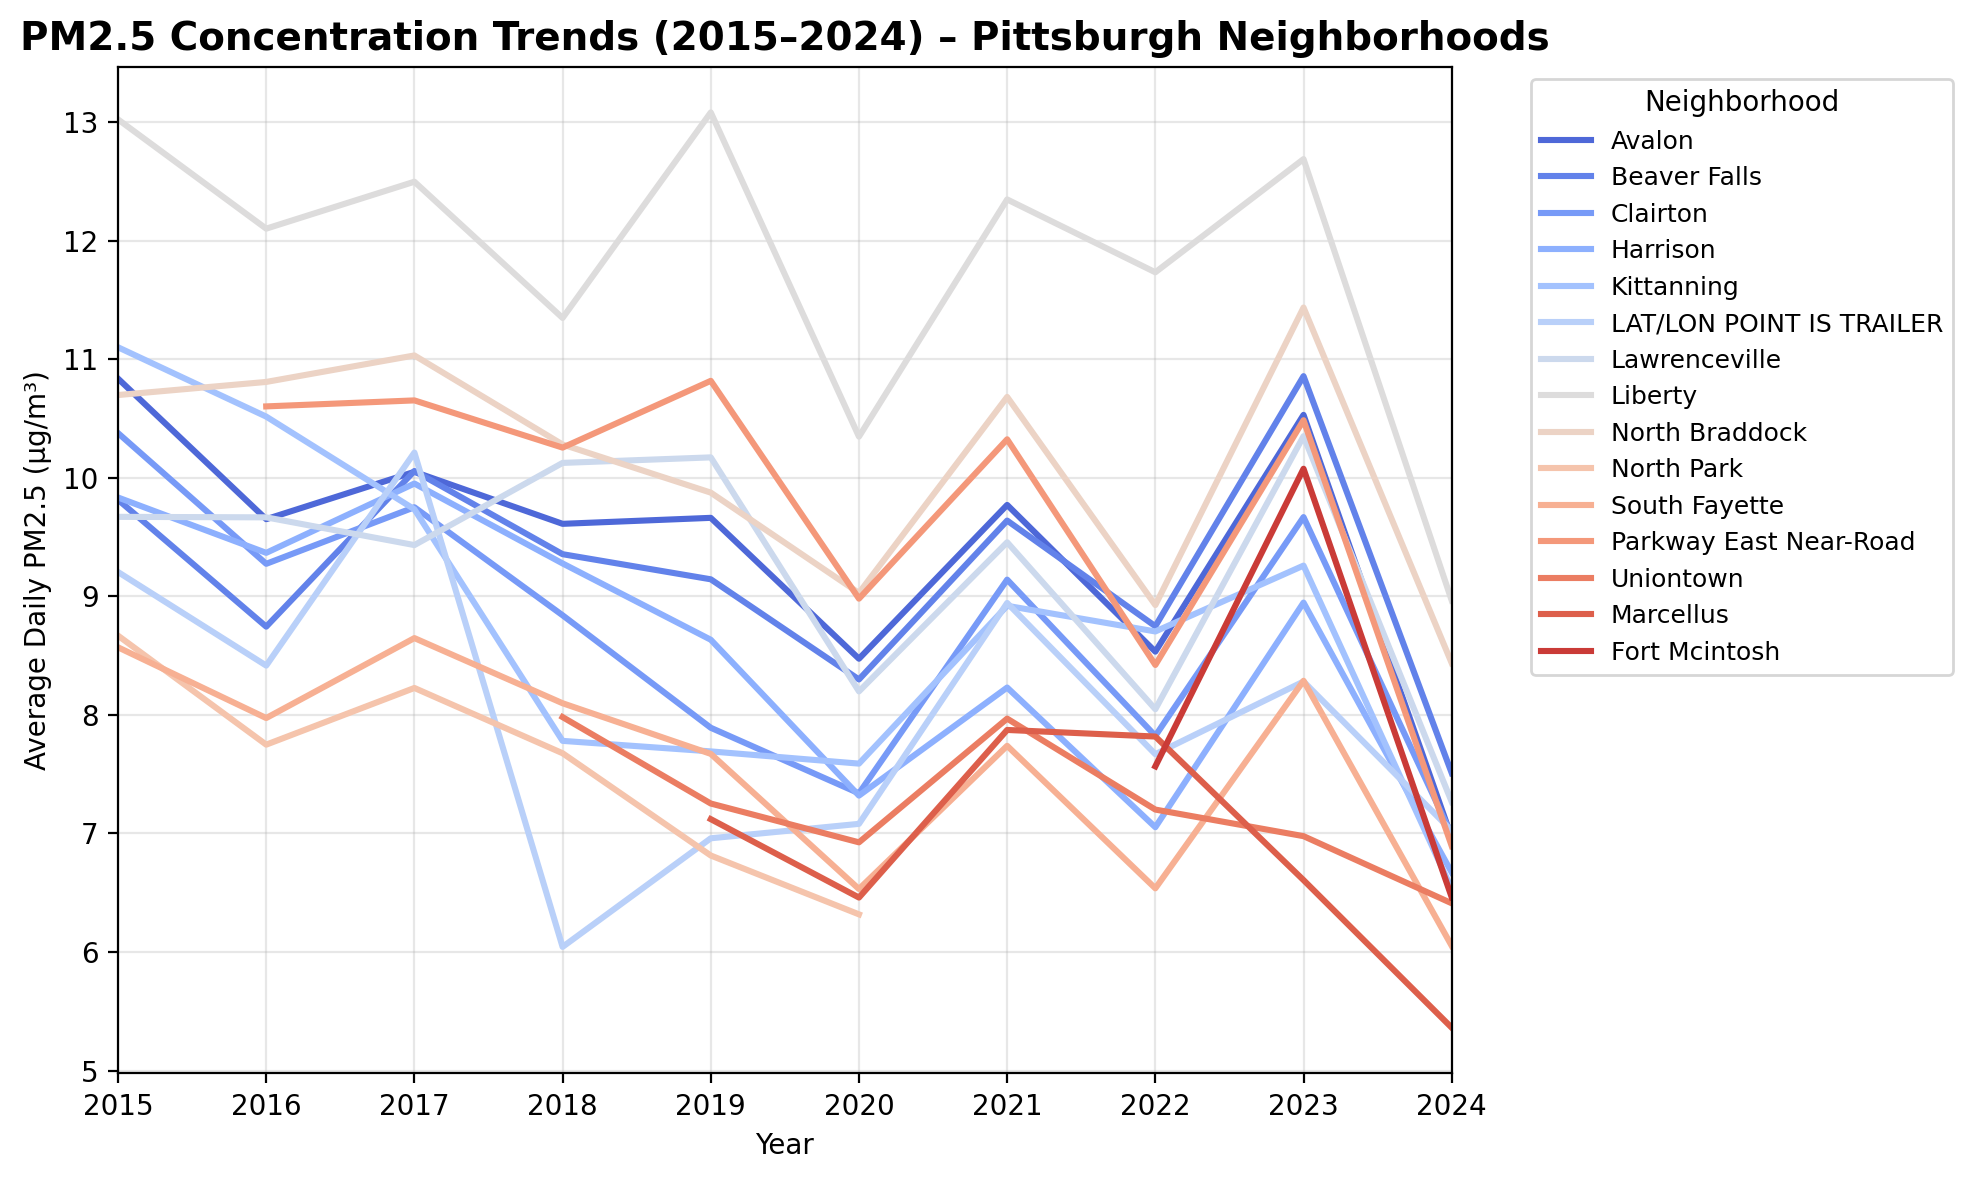


Legend:
- Each line represents one PM2.5 monitoring site in the Pittsburgh metropolitan area.
- The color of each line (cool → warm) represents the neighborhood identity.
- Y-axis: Average daily PM2.5 concentration (µg/m³)
- X-axis: Year (2015–2024)


Key Findings:
• Overall PM2.5 levels show a declining trend from 2015 to 2024, reflecting improved air quality.
• Certain areas (e.g., Avalon, Liberty) still show occasional spikes due to industrial and traffic emissions.
• Seasonal and year-to-year variability persists, suggesting influence from weather and local pollution sources.
• Data consistency (100% completeness) confirms stable monitoring across years.



In [11]:
# === (i) Title ===
# Air Quality Variations across Pittsburgh Neighborhoods (2015–2024)
# Visualization: Yearly PM2.5 Concentration Trends

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import matplotlib.colors as mcolors

# === (ii) Load and Aggregate Data ===
files = sorted(glob.glob("ad_viz_plotval_data_20*.csv"))
dfs = [pd.read_csv(f) for f in files]
data = pd.concat(dfs, ignore_index=True)

# Standardize column names
data.columns = [c.strip().replace(" ", "_") for c in data.columns]
data["Date"] = pd.to_datetime(data["Date"])
data["Year"] = data["Date"].dt.year

# Aggregate yearly mean by Local Site Name
yearly_mean = (
    data.groupby(["Year", "Local_Site_Name"])["Daily_Mean_PM2.5_Concentration"]
    .mean()
    .reset_index()
)

# === (iii) Create Main Figure ===
fig, ax = plt.subplots(figsize=(10, 6), dpi=200)

sns.lineplot(
    data=yearly_mean,
    x="Year",
    y="Daily_Mean_PM2.5_Concentration",
    hue="Local_Site_Name",
    palette="coolwarm",
    linewidth=2.2,
    ax=ax
)

ax.set_title("PM2.5 Concentration Trends (2015–2024) – Pittsburgh Neighborhoods", fontsize=14, weight="bold")
ax.set_xlabel("Year")
ax.set_ylabel("Average Daily PM2.5 (µg/m³)")

# === Show all years on x-axis ===
ax.set_xticks(range(2015, 2025, 1))
ax.set_xlim(2015, 2024)

ax.legend(
    title="Neighborhood",
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    fontsize=9
)
ax.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("PM25_Pittsburgh_Trends.png", dpi=300)
plt.show()

# === (iv) Legend Explanation ===
print("""
Legend:
- Each line represents one PM2.5 monitoring site in the Pittsburgh metropolitan area.
- The color of each line (cool → warm) represents the neighborhood identity.
- Y-axis: Average daily PM2.5 concentration (µg/m³)
- X-axis: Year (2015–2024)
""")

# === (v) Findings ===
print("""
Key Findings:
• Overall PM2.5 levels show a declining trend from 2015 to 2024, reflecting improved air quality.
• Certain areas (e.g., Avalon, Liberty) still show occasional spikes due to industrial and traffic emissions.
• Seasonal and year-to-year variability persists, suggesting influence from weather and local pollution sources.
• Data consistency (100% completeness) confirms stable monitoring across years.
""")


Shapefile loaded. Columns: Index(['OBJECTID', 'fid_blockg', 'statefp10', 'countyfp10', 'tractce10',
       'blkgrpce10', 'geoid10', 'namelsad10', 'mtfcc10', 'funcstat10',
       'aland10', 'awater10', 'intptlat10', 'intptlon10', 'shape_leng',
       'fid_neighb', 'perimeter', 'neighbor_', 'neighbor_i', 'hood', 'hood_no',
       'acres', 'sqmiles', 'dpwdiv', 'unique_id', 'sectors', 'shape_le_1',
       'shape_ar_1', 'page_numbe', 'plannerass', 'created_us', 'created_da',
       'last_edite', 'last_edi_1', 'temp', 'pghdb_sde_', 'GlobalID',
       'Shape__Are', 'Shape__Len', 'geometry'],
      dtype='object')


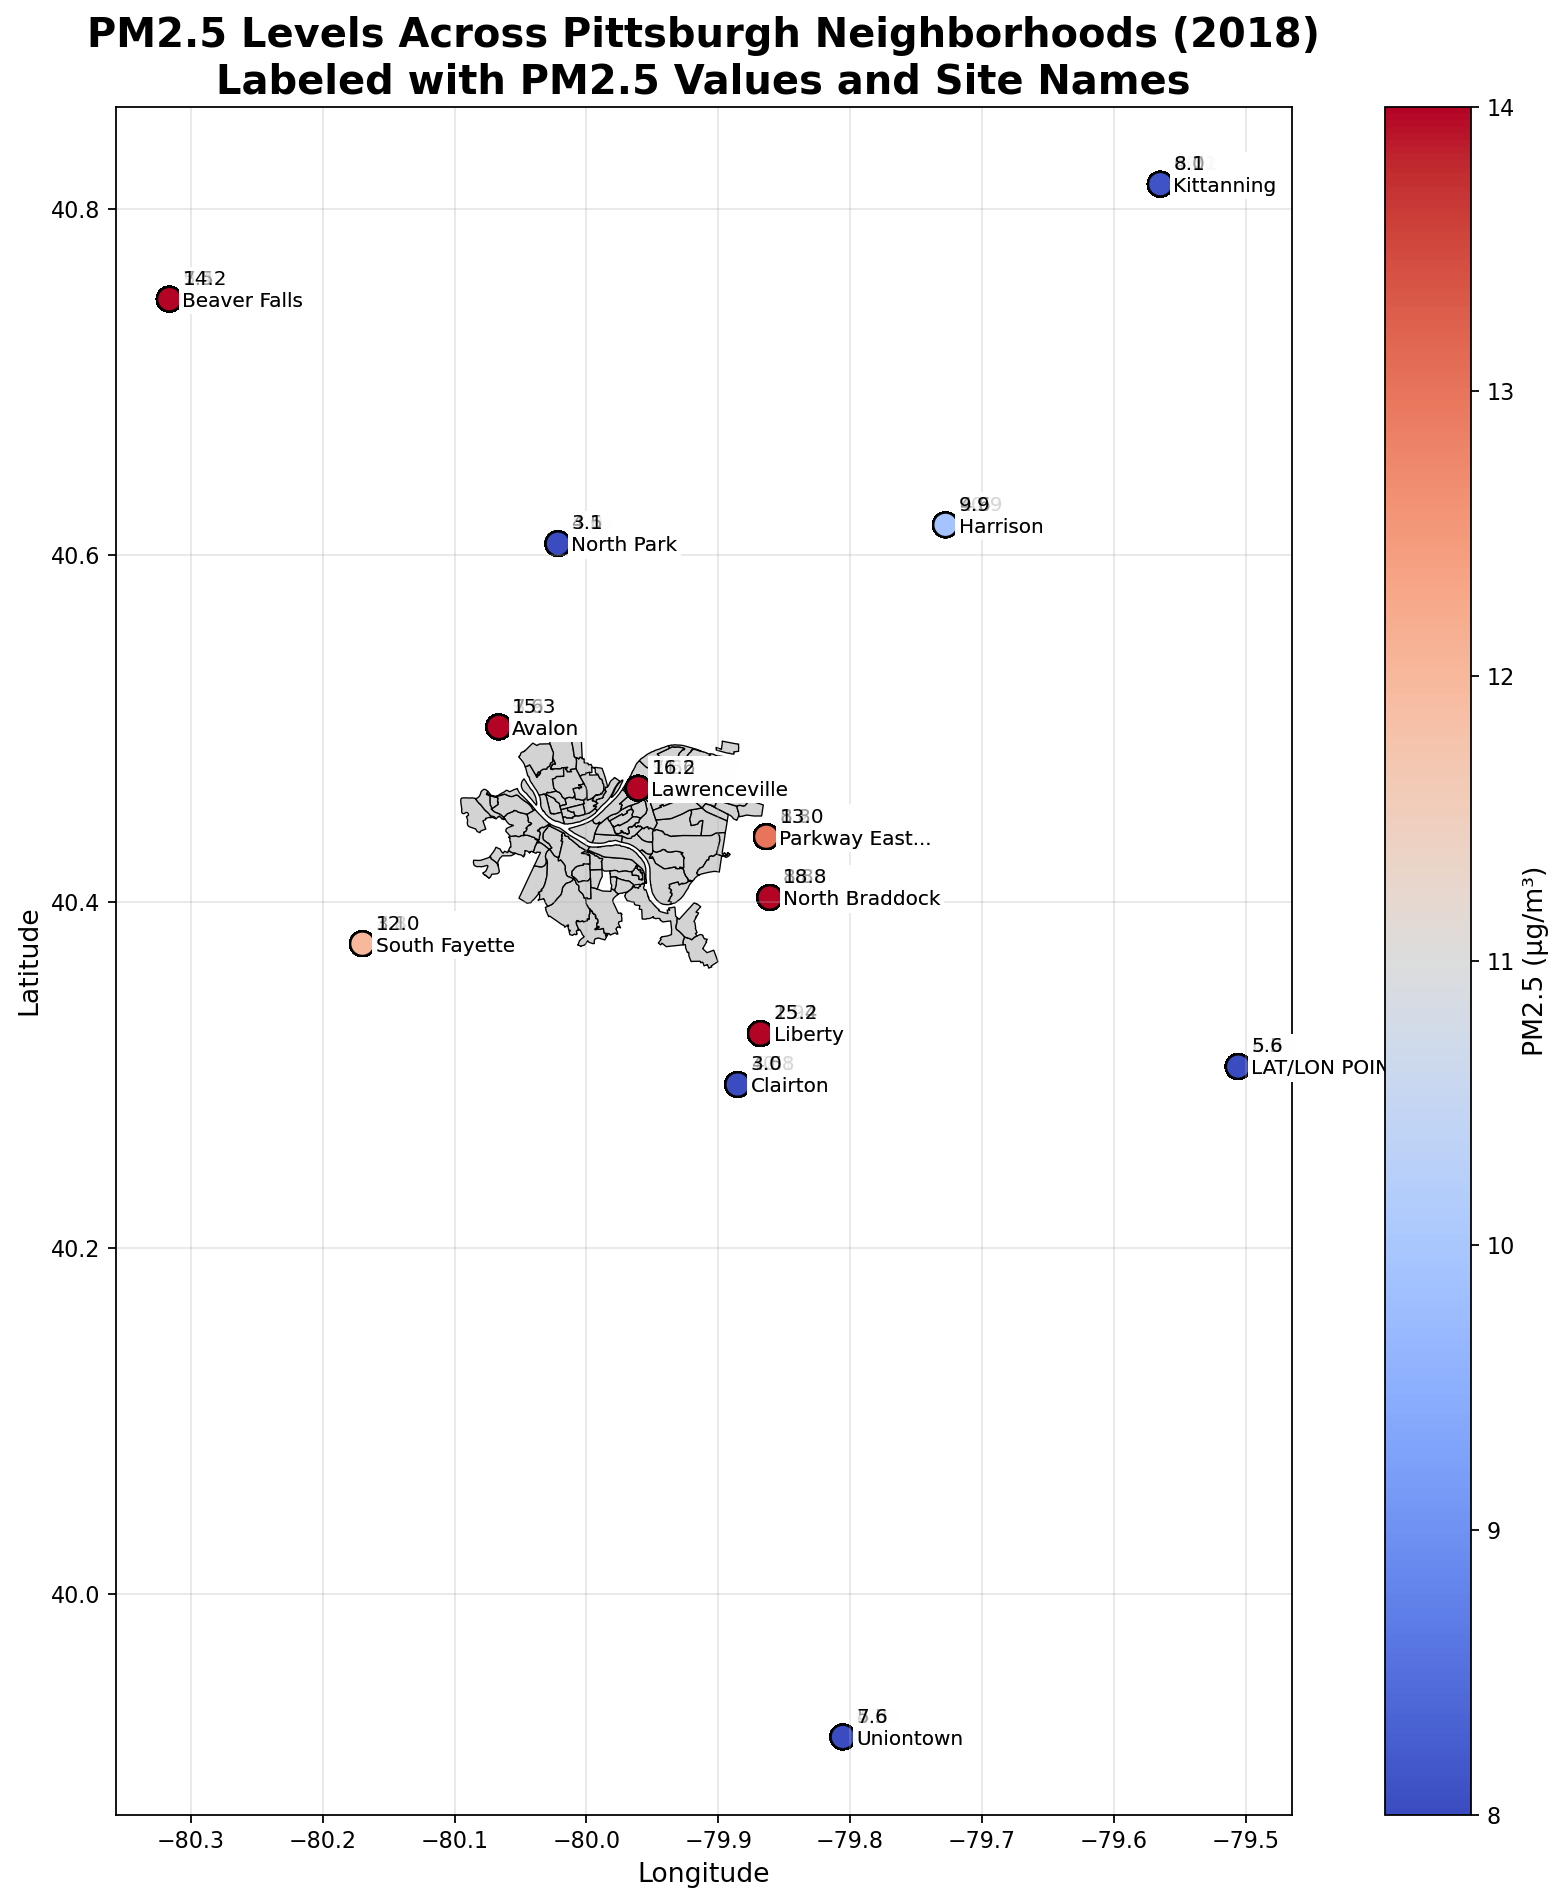

In [ ]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

# -----------------------------------------
# (1) Load PM2.5 2018 Data
# -----------------------------------------
df = pd.read_csv("ad_viz_plotval_data_2018.csv")
df.columns = [c.strip().replace(" ", "_") for c in df.columns]

# Keep necessary columns
df = df[[
    "Site_Latitude",
    "Site_Longitude",
    "Local_Site_Name",
    "Daily_Mean_PM2.5_Concentration"
]].dropna()

# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Site_Longitude, df.Site_Latitude),
    crs="EPSG:4326"
)

# -----------------------------------------
# (2) Load Shapefile (Pittsburgh Neighborhood Boundaries)
# -----------------------------------------
pgh_map = gpd.read_file("Neighborhoods_.shp")

# Ensure CRS match
if pgh_map.crs != "EPSG:4326":
    pgh_map = pgh_map.to_crs("EPSG:4326")

print("Shapefile loaded. Columns:", pgh_map.columns)

# -----------------------------------------
# (3) Plot Map
# -----------------------------------------
fig, ax = plt.subplots(figsize=(12, 12), dpi=160)

# Plot polygons only as background map
pgh_map.plot(
    color="lightgrey",
    edgecolor="black",
    linewidth=0.6,
    ax=ax
)

# Scatter points colored by PM2.5 (manual vmin/vmax for better contrast)
sc = ax.scatter(
    df["Site_Longitude"],
    df["Site_Latitude"],
    c=df["Daily_Mean_PM2.5_Concentration"],
    cmap="coolwarm",
    s=120,                      # circle size
    edgecolor="black",
    vmin=8, vmax=14             # custom color range
)

# Add colorbar
cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)

# -----------------------------------------
# (4) Fast, clean labeling (PM2.5 + Neighborhood)
# -----------------------------------------
for i, row in df.iterrows():

    site = str(row["Local_Site_Name"])
    pm = row["Daily_Mean_PM2.5_Concentration"]

    # Remove non-ASCII characters to avoid black blocks
    site = ''.join([c for c in site if ord(c) < 128])

    # Truncate too long names
    if len(site) > 15:
        site = site[:12] + "..."

    ax.text(
        row["Site_Longitude"] + 0.01,   # horizontal offset
        row["Site_Latitude"] + 0.005,   # vertical offset
        f"{pm:.1f}\n{site}",
        fontsize=9,
        weight="regular",
        color="black",
        ha="left",
        va="center",
        bbox=dict(alpha=0.6, edgecolor="none", pad=1.5)
    )

# -----------------------------------------
# (5) Final formatting
# -----------------------------------------
plt.title(
    "PM2.5 Levels Across Pittsburgh Neighborhoods (2018)\nLabeled with PM2.5 Values and Site Names",
    fontsize=18,
    weight="bold"
)

plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig("PM25_Pittsburgh_2018_Labeled.png", dpi=300)
plt.show()


In [9]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# ---------------------------------------------------------
# Load PM2.5 Data
# ---------------------------------------------------------
df = pd.read_csv("ad_viz_plotval_data_2018.csv")
df.columns = [c.strip().replace(" ", "_") for c in df.columns]
df = df[["Site_Latitude", "Site_Longitude", "Daily_Mean_PM2.5_Concentration"]].dropna()

# Geo points
gdf_points = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.Site_Longitude, df.Site_Latitude),
    crs="EPSG:4326"
)

# Load map
pgh_map = gpd.read_file("Neighborhoods_.shp")
if pgh_map.crs != "EPSG:4326":
    pgh_map = pgh_map.to_crs("EPSG:4326")

print(joined[neicol].unique())

# ---------------------------------------------------------
# Plot
# ---------------------------------------------------------
fig, ax = plt.subplots(figsize=(6, 6), dpi=150)

pgh_map.plot(color="lightgrey", edgecolor="gray", linewidth=0.6, ax=ax)

# PM2.5 color scale (tight range)
vmin = 8
vmax = 15

scatter = ax.scatter(
    df["Site_Longitude"],
    df["Site_Latitude"],
    c=df["Daily_Mean_PM2.5_Concentration"],
    cmap="coolwarm",
    s=100,
    edgecolor="black",
    linewidth=0.7,
    vmin=vmin - 0.2,
    vmax=vmax + 0.2
)

# ---------------------------------------------------------
# FAST labeling (no adjustText)
# Manual font size, weight, color
# ---------------------------------------------------------

LABEL_FONTSIZE = 12        # 字体大小（你可以改成 8, 10, 12…）
LABEL_WEIGHT = "light" # 字体粗细: "light", "regular", "semibold", "bold", "heavy"
LABEL_COLOR = "black"     # 字体颜色，可选 "gray", "white", "#333333" 等
X_OFFSET = 0.008          # X 偏移量（越大越远）
Y_OFFSET = 0.004          # Y 偏移量（越大越远）

for i, row in df.iterrows():
    ax.text(
        row["Site_Longitude"] + X_OFFSET,
        row["Site_Latitude"] + Y_OFFSET,
        f"{row['Daily_Mean_PM2.5_Concentration']:.1f}",
        fontsize=LABEL_FONTSIZE,
        weight=LABEL_WEIGHT,
        color=LABEL_COLOR,
        ha='left',     # 水平靠左（避免遮挡点）
        va='center'    # 垂直居中
    )


# ---------------------------------------------------------
# Colorbar
# ---------------------------------------------------------
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label("PM2.5 (µg/m³)", fontsize=12)

plt.title(
    "PM2.5 Levels Across Pittsburgh Monitoring Sites (2018))",
    fontsize=16, weight="bold"
)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("PM25_Pittsburgh_2018_fast.png", dpi=300)
plt.show()


NameError: name 'joined' is not defined